In [1]:
!pip install pyspark

     |████████████████████████████████| 204.2 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 55.4 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=57d3ee8d2e8b462e271807bb9165eaf9722432f78317241c644531280372ab60
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import warnings
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, isnan, when, count, trim, desc, sum, asc
from pyspark.sql.functions import countDistinct, explode, split, concat_ws, collect_list
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType as R, StructField as Fld, DoubleType as Dbl, StringType as Str, IntegerType as Int, DateType as Date
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [3]:
spark = SparkSession \
    .builder \
    .appName("antioxidants analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
dSchema = R([
            Fld("product",Str()),
            Fld("origin",Str()),
            Fld("procured_in",Str()),
            Fld("antioxi_mmol_100g", Dbl())
            ])

In [52]:
#read in tables
dffruits = spark.read.csv("../input/fruits/Fruit.csv", header=True, schema=dSchema)
dfvegetables = spark.read.csv("../input/vegetables/Vegetables.csv", header = True, schema=dSchema)
dfnuts = spark.read.csv("../input/nuts-and-seeds/Nuts and seeds.csv", header = True, schema=dSchema)

In [53]:
dffruits = dffruits.withColumn('category', lit('Fruit')).drop('origin')
dffruits.show(5, truncate = True)
dffruits.count()

+--------------------+-----------+-----------------+--------+
|             product|procured_in|antioxi_mmol_100g|category|
+--------------------+-----------+-----------------+--------+
| Amla berries, dried|      India|           261.53|   Fruit|
|Amla, Indian Goos...|      India|            13.27|   Fruit|
|Amla, syrup from ...|      India|             29.7|   Fruit|
|Apples, Composite...|        USA|             0.31|   Fruit|
|       Apples, dried|     Norway|             3.49|   Fruit|
+--------------------+-----------+-----------------+--------+
only showing top 5 rows



398

In [91]:
dfvegetables = dfvegetables.withColumn('category', lit('Vegetables')).drop('origin')
dfvegetables.show(5, truncate = True)
dfvegetables.count()

+--------------------+-----------+-----------------+----------+
|             product|procured_in|antioxi_mmol_100g|  category|
+--------------------+-----------+-----------------+----------+
|        Alfa sprouts|     Norway|             0.14|Vegetables|
|           Artichoke|     Norway|             0.69|Vegetables|
|   Artichoke, boiled|        USA|             3.89|Vegetables|
|   Artichoke, boiled|        USA|             4.54|Vegetables|
|Artichoke, brine ...|        USA|             3.36|Vegetables|
+--------------------+-----------+-----------------+----------+
only showing top 5 rows



303

In [92]:
dfnuts = dfnuts.withColumn('category', lit('Nuts')).drop('origin')
dfnuts.show(5, truncate = True)
dfnuts.count()

+--------------------+-----------+-----------------+--------+
|             product|procured_in|antioxi_mmol_100g|category|
+--------------------+-----------+-----------------+--------+
|Almonds, with pel...|     Norway|             0.23|    Nuts|
|Almonds, with pel...|     Norway|             0.37|    Nuts|
|Almonds, with pel...|     Norway|             0.28|    Nuts|
|Almonds, with pel...|        USA|             0.53|    Nuts|
|Almonds, with pel...|     Norway|             0.26|    Nuts|
+--------------------+-----------+-----------------+--------+
only showing top 5 rows



90

In [93]:
#union 3 tables
All = dffruits.unionAll(dfvegetables).unionAll(dfnuts)
All = All.withColumn("pid",F.monotonically_increasing_id())
All.show(5, truncate = True)
All.count()

+--------------------+-----------+-----------------+--------+---+
|             product|procured_in|antioxi_mmol_100g|category|pid|
+--------------------+-----------+-----------------+--------+---+
| Amla berries, dried|      India|           261.53|   Fruit|  0|
|Amla, Indian Goos...|      India|            13.27|   Fruit|  1|
|Amla, syrup from ...|      India|             29.7|   Fruit|  2|
|Apples, Composite...|        USA|             0.31|   Fruit|  3|
|       Apples, dried|     Norway|             3.49|   Fruit|  4|
+--------------------+-----------+-----------------+--------+---+
only showing top 5 rows



791

In [94]:
#simplify product name
All = All.withColumn('productArray', split(col("product"),",")).drop('product')
All = All.withColumn('product', col('productArray')[0]).drop('productArray')
All.show(5)

+-----------+-----------------+--------+---+------------+
|procured_in|antioxi_mmol_100g|category|pid|     product|
+-----------+-----------------+--------+---+------------+
|      India|           261.53|   Fruit|  0|Amla berries|
|      India|            13.27|   Fruit|  1|        Amla|
|      India|             29.7|   Fruit|  2|        Amla|
|        USA|             0.31|   Fruit|  3|      Apples|
|     Norway|             3.49|   Fruit|  4|      Apples|
+-----------+-----------------+--------+---+------------+
only showing top 5 rows



In [95]:
anti_category = All.groupBy("category").agg(F.avg("antioxi_mmol_100g").alias('avg_antioxidant')).orderBy(desc('avg_antioxidant'))
anti_category.show(truncate = False)

+----------+------------------+
|category  |avg_antioxidant   |
+----------+------------------+
|Nuts      |4.574333333333334 |
|Fruit     |3.8280352644836197|
|Vegetables|0.8024752475247526|
+----------+------------------+



In [96]:
anti_product = All.groupBy("product").agg(F.avg("antioxi_mmol_100g").alias('avg_antioxidant')).orderBy(desc('avg_antioxidant'))
anti_product.show(5, truncate=False)

+-----------------------------------+---------------+
|product                            |avg_antioxidant|
+-----------------------------------+---------------+
|Amla berries                       |261.53         |
|Dog Roseshell                      |75.84          |
|Leaves from the African Baobab tree|48.07          |
|Dog Rose                           |33.6075        |
|Zereshk                            |27.3           |
+-----------------------------------+---------------+
only showing top 5 rows



In [97]:
#using Spark Sql to analyze the data
All.createOrReplaceTempView("All")     

In [98]:
#top 10 fruits high in antioxidants
top_10_fruits = spark.sql("""select distinct
             product,
             avg(antioxi_mmol_100g) as avg_antioxidants
             from All
             where category = 'Fruit' and procured_in = "USA"
             group by product
             order by avg_antioxidants desc
             limit 10
""")

In [99]:
top_10_fruits = top_10_fruits.toPandas()

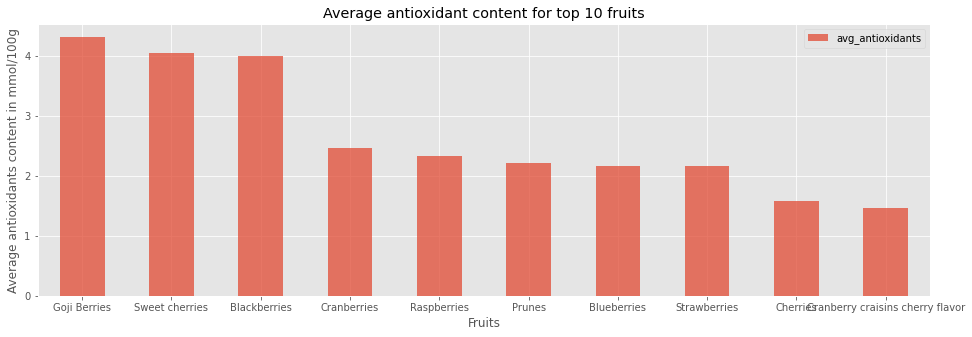

In [100]:
top_10_fruits.plot.bar(
  x="product",
  y="avg_antioxidants",
  figsize=(16, 5),
  rot=0,
  alpha=0.75,
)

plt.title('Average antioxidant content for top 10 fruits')
plt.xlabel('Fruits')
plt.ylabel('Average antioxidants content in mmol/100g')
plt.show()

In [102]:
#top 10 vegetables high in antioxidants
top_10_vegs = spark.sql("""select distinct
             product,
             avg(antioxi_mmol_100g) as avg_antioxidants
             from All
             where category = 'Vegetables' and procured_in = "USA"
             group by product
             order by avg_antioxidants desc
             limit 10
""")

In [103]:
top_10_vegs = top_10_vegs.toPandas()

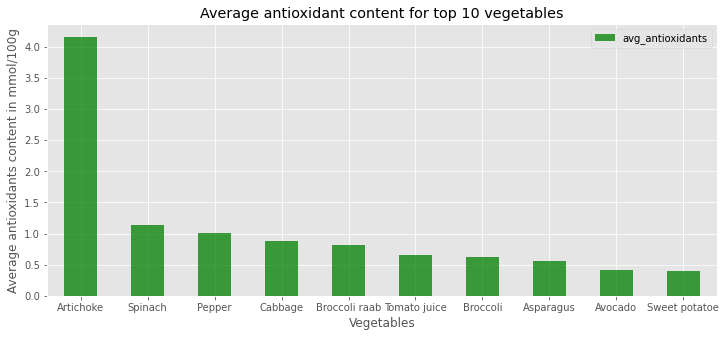

In [104]:
top_10_vegs.plot.bar(
  x="product",
  y="avg_antioxidants",
  figsize=(12, 5),
  rot=0,
  alpha=0.75,
  color=['g']
)

plt.title('Average antioxidant content for top 10 vegetables')
plt.xlabel('Vegetables')
plt.ylabel('Average antioxidants content in mmol/100g')
plt.show()

In [105]:
#top 10 nuts high in antioxidants
top_10_nuts = spark.sql("""select distinct
             product,
             avg(antioxi_mmol_100g) as avg_antioxidants
             from All
             where category = 'Nuts' and procured_in = "USA"
             group by product
             order by avg_antioxidants desc
             limit 10
""")

In [106]:
top_10_nuts = top_10_nuts.toPandas()

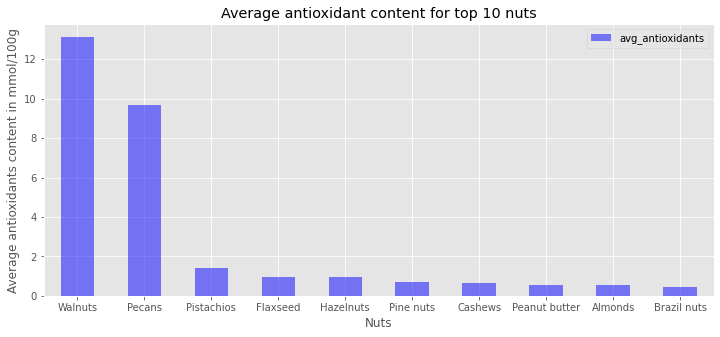

In [107]:
top_10_nuts.plot.bar(
  x="product",
  y="avg_antioxidants",
  figsize=(12, 5),
  rot=0,
  alpha=0.5,
  color=['b']
)

plt.title('Average antioxidant content for top 10 nuts')
plt.xlabel('Nuts')
plt.ylabel('Average antioxidants content in mmol/100g')
plt.show()

In [114]:
#import txt file with 30 selected food and their prices
dfprices = spark.read.option("header", "true") \
    .option("delimiter", "|") \
    .option("inferSchema", "true") \
    .csv("../input/prices/30_products_w_prices.txt")

dfprices.show(10, truncate=False)

+-----------------+---------------------+---------------+
|product          |avg_antioxi_mmol_100g|price_per_pound|
+-----------------+---------------------+---------------+
|Goji Berries     |4.31                 |13.99          |
|Sweet cherries   |4.05                 |5.05           |
|Blackberries     |3.99                 |2.0            |
|Cranberries      |2.47                 |10.99          |
|Raspberries      |2.33                 |8.4            |
|Prunes           |2.21                 |4.99           |
|Blueberries      |2.17                 |2.0            |
|Strawberries     |2.16                 |2.4            |
|Cherries         |1.57                 |2.25           |
|Plums            |1.33                 |1.99           |
+-----------------+---------------------+---------------+
only showing top 10 rows



In [115]:
dfprices.columns

['product', 'avg_antioxi_mmol_100g', 'price_per_pound']

In [116]:
#using Spark Sql to analyze the data
dfprices.createOrReplaceTempView("dfprices")     

In [137]:
antioxi_price = spark.sql("""select distinct
             product,
             avg_antioxi_mmol_100g as avg_antioxidants,
             price_per_pound as price_per_pound,
             avg_antioxi_mmol_100g/0.22/price_per_pound as antioxidant_one_dollar
             from dfprices
             order by antioxidant_one_dollar desc
             limit 10
""")

In [138]:
antioxi_price = antioxi_price.toPandas()

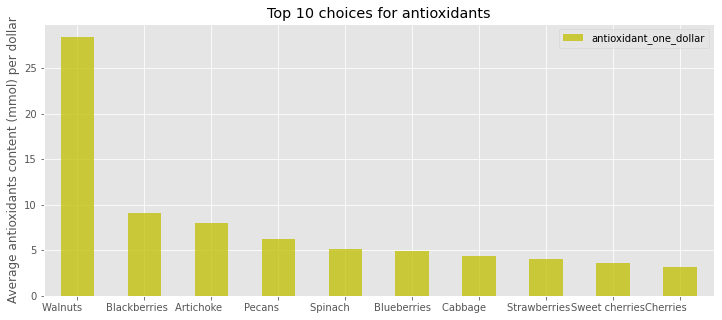

In [141]:
antioxi_price.plot.bar(
  x="product",
  y="antioxidant_one_dollar",
  figsize=(12, 5),
  rot=0,
  alpha=0.75,
  color=['y']
)

plt.title('Top 10 choices for antioxidants')
plt.xlabel('')
plt.ylabel('Average antioxidants content (mmol) per dollar')
plt.show()

****